In [1]:
import json
import glob
import matplotlib.pylab as plt
import numpy as np
from scipy.special import erf
import sys
sys.path.append('./../../Figures/')
import makeCorner
from fig_helper_functions import draw_chiEffs_and_chiPs_betaDoubleGauss
from scipy.stats import gaussian_kde

sys.path.append('./../../Code/PopulationInference')
from posterior_helper_functions import *

In [2]:
# For checking the progress of runs: 
for pop in ['1', '2', '3']:

    run = f'103123_betaPlusDoubleGaussian2_noSelectionSpins_pop{pop}_300events'
    chains = np.sort(glob.glob(".tmp/{0}_r??.npy".format(run)))
    full_chain = np.concatenate([np.load(chain) for chain in chains], axis=1)
    
    print(pop, full_chain.shape)

1 (20, 20000, 8)
2 (20, 20000, 8)
3 (20, 20000, 8)


Load `.json` result files which contains
1. direct output from `emcee` interference, without any processing
2. post-processed output from `emcee` inference

and make dict containing info for all populations under the given model

In [3]:
# For loading files
model = 'betaPlusDoubleGaussian2_noSelectionSpins'
pops = ['1', '2', '3']
nevents = ['70', '300'] 
date = '103123'

# Make Dict
data_dict = {}

# Cycle through the different populations and no. of events
for pop in pops: 
    data_pop = {}
    for nevent in nevents: 
        
        print(pop, nevent)
        
        name = f"{date}_{model}_pop{pop}_{nevent}events"
        
        with open(f'{model}/{name}.json', 'r') as f:
            data = json.load(f)
            
        data_pop[nevent+' events'] = data    
            
    data_dict['pop '+pop] = data_pop

1 70
1 300
2 70
2 300
3 70
3 300


In [4]:
# Names of populations from paper for plotting below
population_labels_dict = {
    'pop 1':r'$\mathrm{\textsc{HighSpinPrecessing}}$', 
    'pop 2':r'$\mathrm{\textsc{MediumSpin}}$', 
    'pop 3':r'$\mathrm{\textsc{LowSpinAligned}}$'
}

# Colors corresponding to different numbers of events
nevents_colors_dict = {
    '70 events':'#8fbcda', 
    '300 events':'#196090',
}

The contents of the file for each population and number of events are the following:

| Parameter (dict key) | Description |
| :-------- | :---------- |
| `mu_chi` | Mean of the spin magnitude beta distribution|
| `sigma_chi` | Standard deviation of the spin magnitude beta distribution |
| `mu1_chi` | Mean of gaussian 1 for the $\cos\theta$ distribution |
| `sigma1_cost` |  Standard deviation of gaussian 1 for the $\cos\theta$ distribution |
| `mu2_chi` | Mean of gaussian 2 for the $\cos\theta$ distribution |
| `sigma2_cost` |  Standard deviation of gaussian 2 for the $\cos\theta$ distribution |
| `MF_cost` |  Fraction in gaussian 1 for the $\cos\theta$ distribution |
| `Bq` | Power-law index on the conditional secondary mass distribution $p(m_2 | m_1)$|

Next, plot our various chains to inspect convergence:

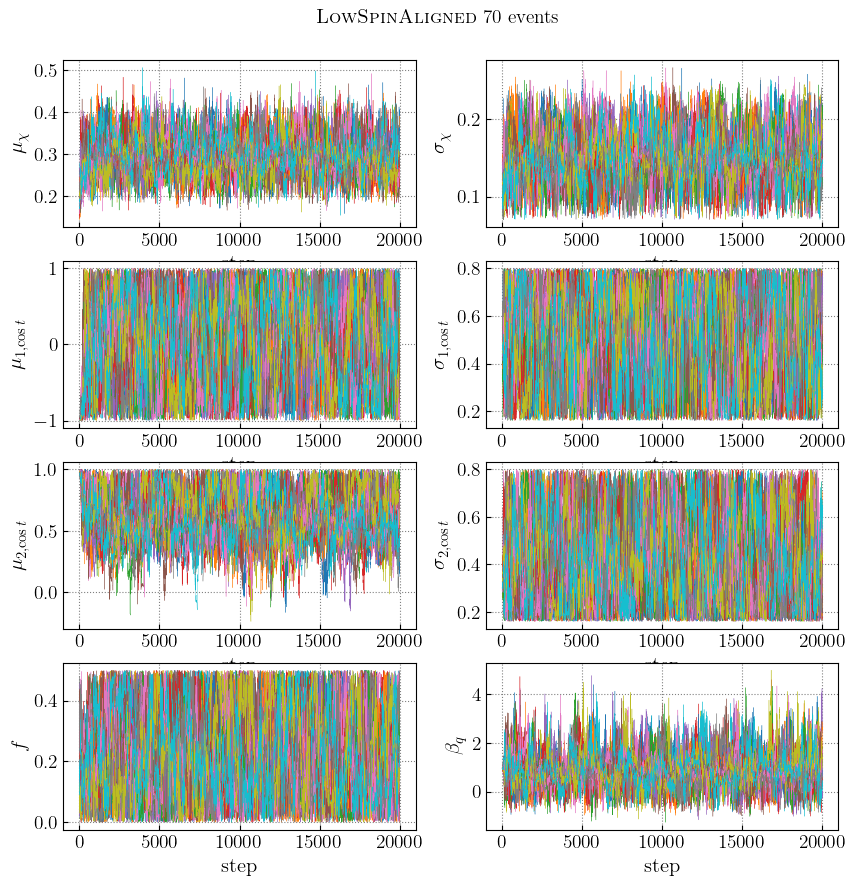

In [5]:
# Select which pop and no. events you want to look at
pop_key = 'pop 3'
nevent_key = '70 events'
data = data_dict[pop_key][nevent_key]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,10))

# mean of chi
for chain in data['mu_chi']['unprocessed']:
    axes[0][0].plot(chain, lw=0.25)
axes[0][0].set_ylabel(r'$\mu_\chi$', fontsize=15)

# sigma of chi
for chain in data['sigma_chi']['unprocessed']:
    axes[0][1].plot(chain, lw=0.25)
axes[0][1].set_ylabel(r'$\sigma_\chi$', fontsize=15)

# mean of gaussian 1 cos(theta)
for chain in data['mu1_cost']['unprocessed']:
    axes[1][0].plot(chain, lw=0.25)
axes[1][0].set_ylabel(r'$\mu_{1, \cos t}$', fontsize=15)

# sigma of gaussian 1 cos(theta)
for chain in data['sigma1_cost']['unprocessed']:
    axes[1][1].plot(chain, lw=0.25)
axes[1][1].set_ylabel(r'$\sigma_{1, \cos t}$', fontsize=15)

# mean of gaussian 2 cos(theta)
for chain in data['mu2_cost']['unprocessed']:
    axes[2][0].plot(chain, lw=0.25)
axes[2][0].set_ylabel(r'$\mu_{2, \cos t}$', fontsize=15)

# sigma of gaussian 2 cos(theta)
for chain in data['sigma2_cost']['unprocessed']:
    axes[2][1].plot(chain, lw=0.25)
axes[2][1].set_ylabel(r'$\sigma_{2, \cos t}$', fontsize=15)

# mixing fraction cos(theta)
for chain in data['MF_cost']['unprocessed']:
    axes[3][0].plot(chain, lw=0.25)
axes[3][0].set_ylabel(r'$f$', fontsize=15)

# beta_q
for chain in data['Bq']['unprocessed']:
    axes[3][1].plot(chain, lw=0.25)
axes[3][1].set_ylabel(r'$\beta_{q}$', fontsize=15)

for ax in axes: 
    for a in ax:
        a.set_xlabel('step', fontsize=15)       
                
plt.suptitle(population_labels_dict[pop_key] + ' ' + nevent_key, y=0.93, fontsize=14)

plt.show()

Let's make a corner plot showing posteriors on our each set of parameters:

In [6]:
# True mu_chi, sigma_chi, mu1_cost, sigma1_cost, mu2_cost, sigma2_cost, f, Bq:
hyperparams = { 
    '1':[0.55, 0.26, 0.42, 0.75, 0.19, 0.18, 0.45, 0.96],  
    '2':[0.32, 0.16, 0.33, 0.64, 0.59, 0.40, 0.36, 0.96],
    '3':[0.19, 0.12, -0.98, 0.44, 0.98, 0.31, 0.26, 0.96]
}

/cvmfs/software.igwn.org/conda/envs/igwn-py38/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


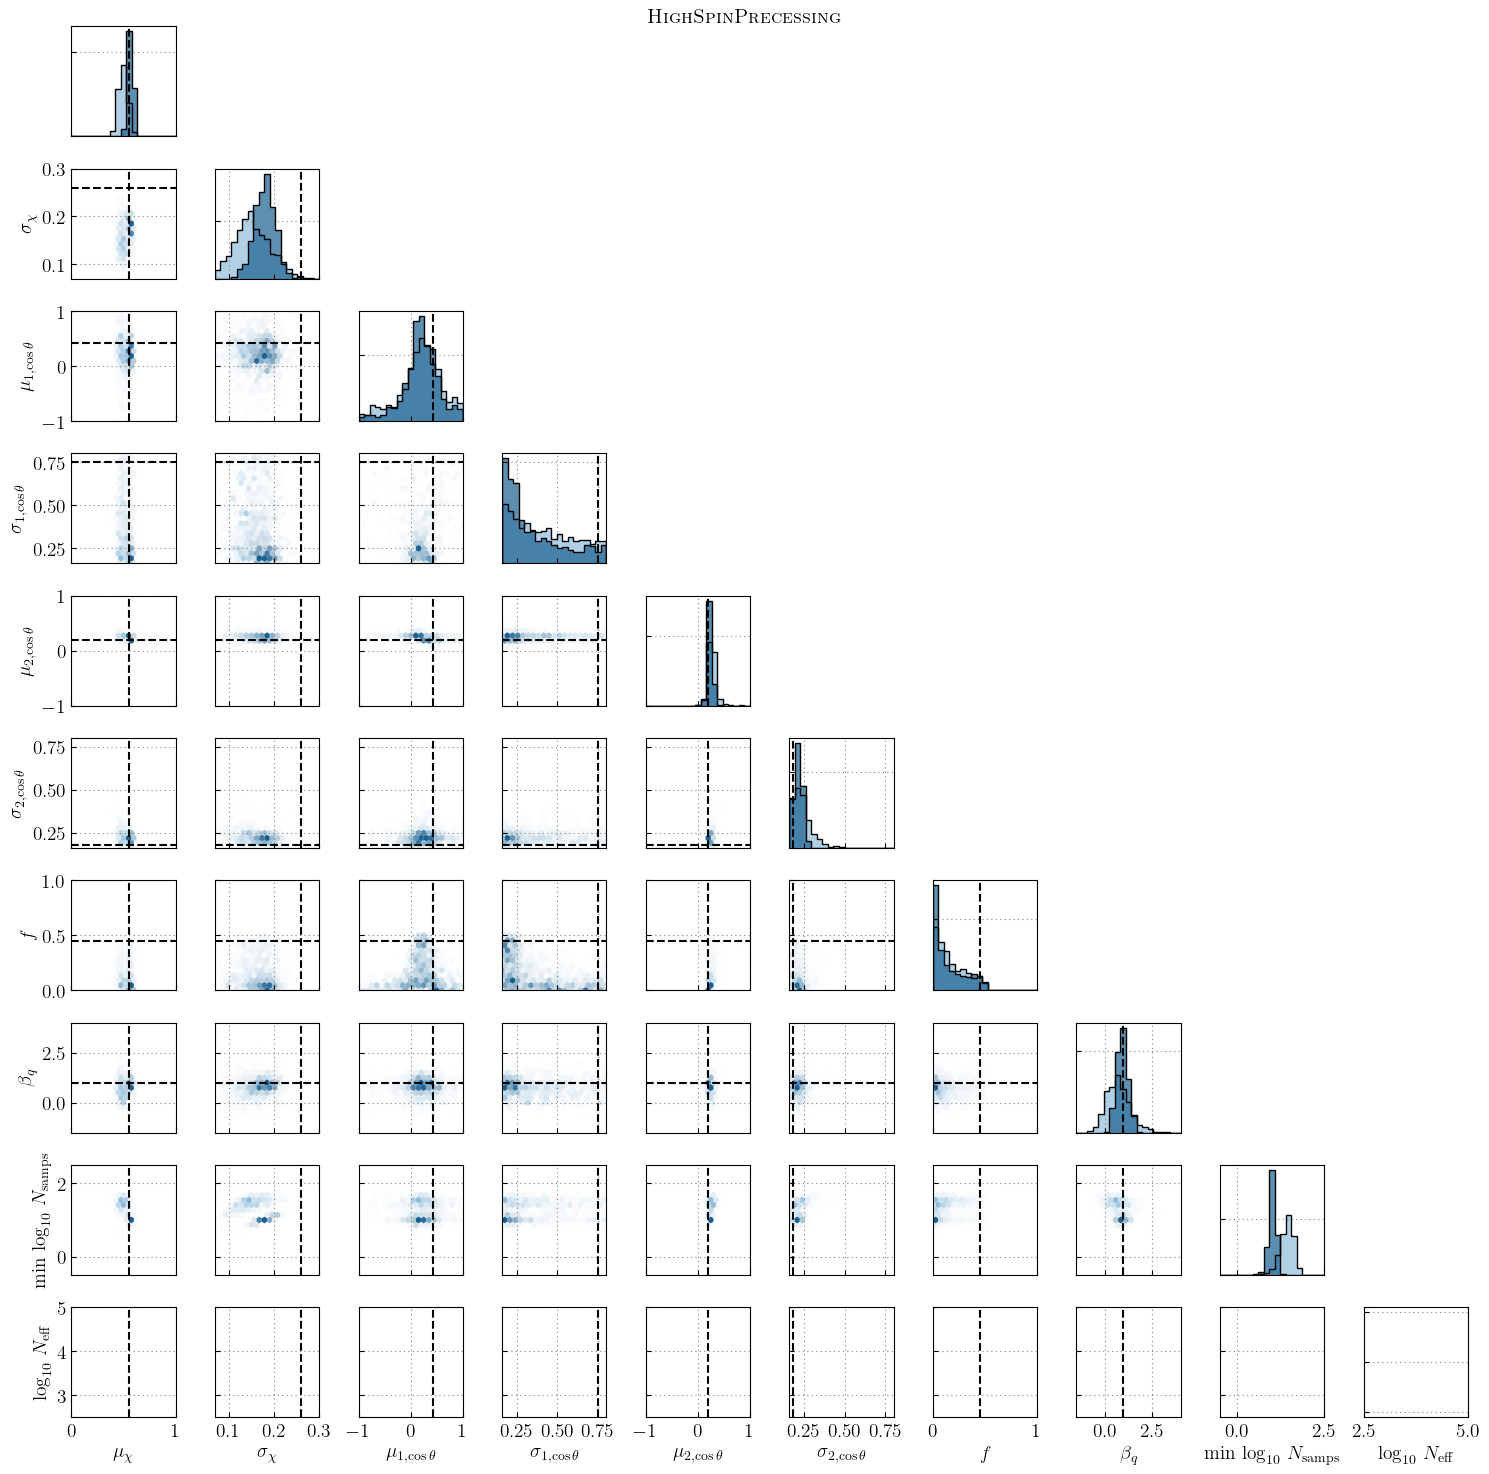

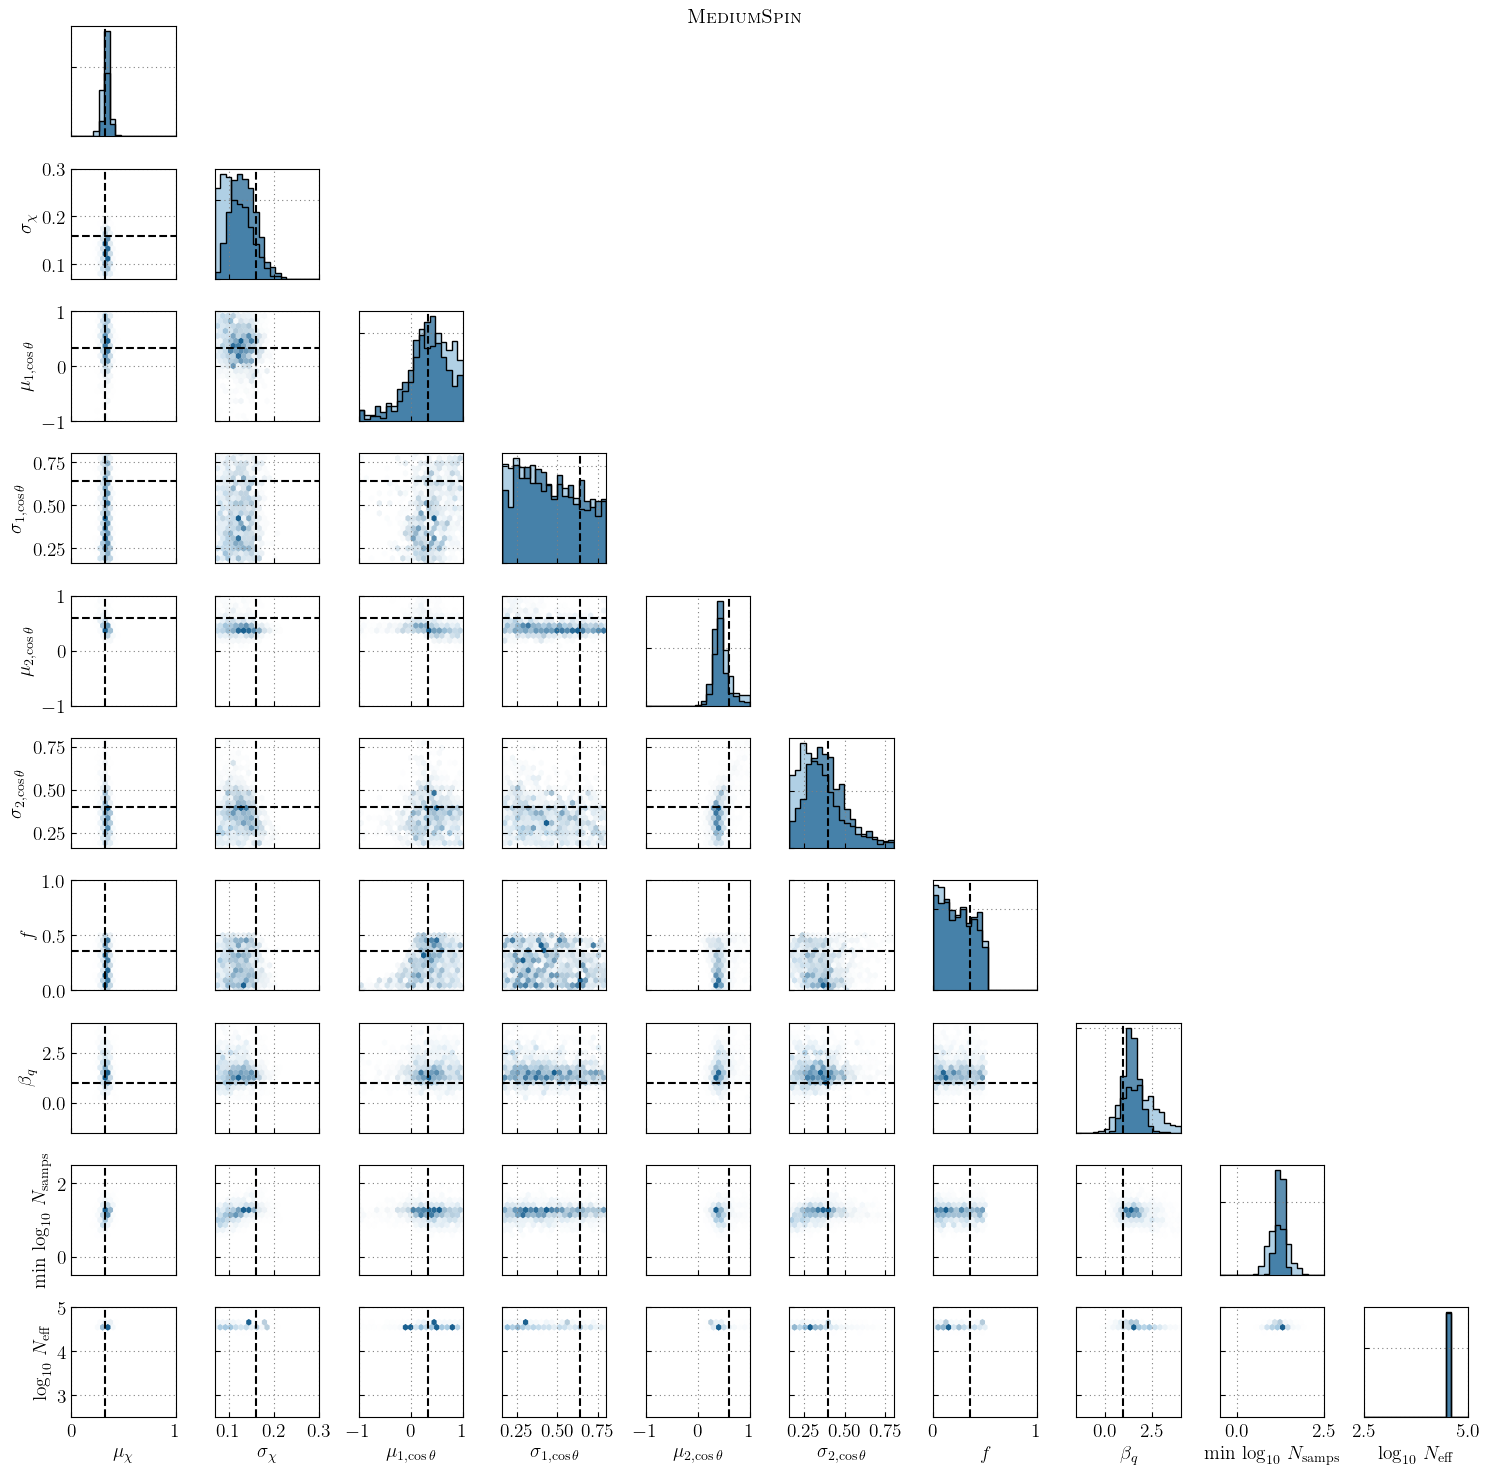

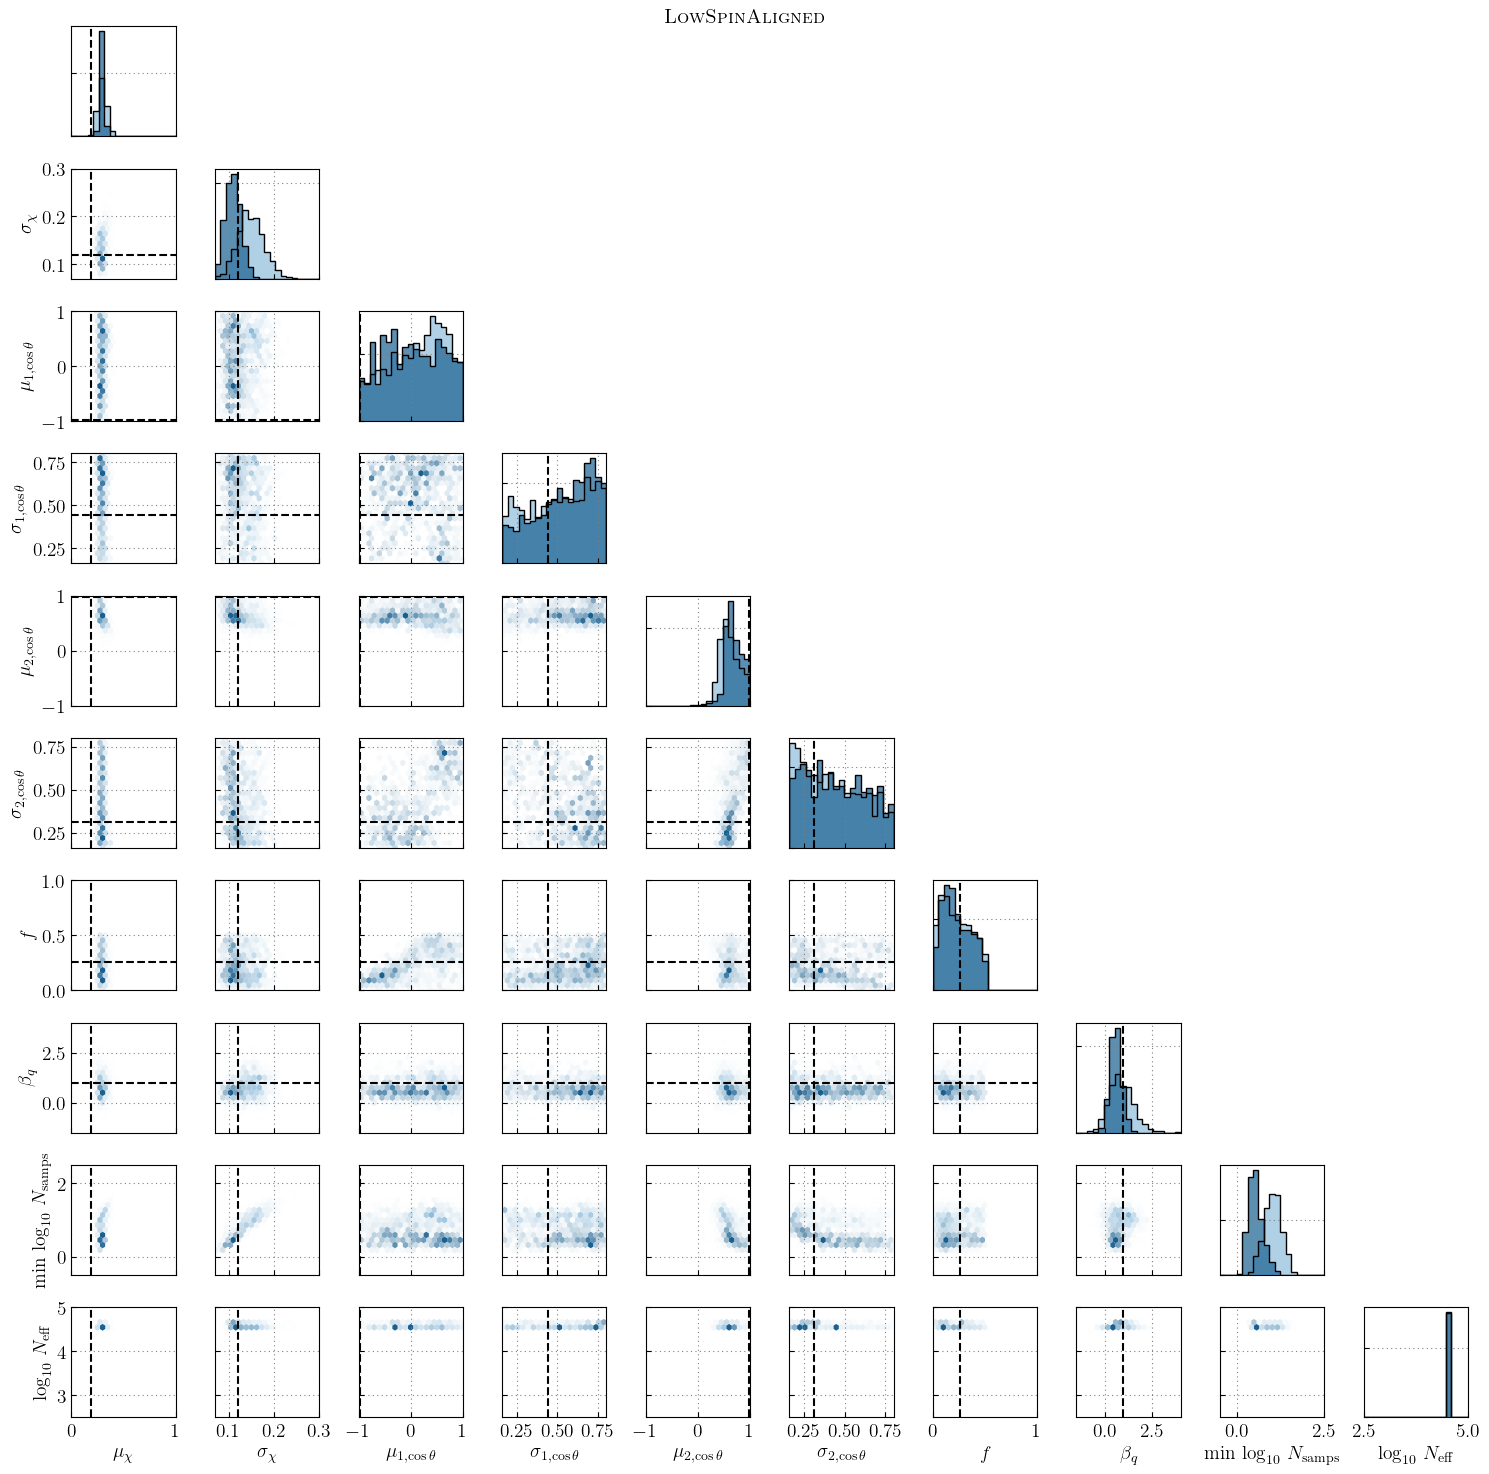

In [7]:
import importlib
importlib.reload(makeCorner)

for pop in pops: 
    
    # Fetch data
    pop_key = 'pop '+pop
    event_key = nevent+' events'
    data = data_dict[pop_key]

    # Plot
    fig = plt.figure(figsize=(15,15))

    toPlot = {
        "mu_chi":{
            "data":{f'{nevent} events':{'posterior':data[f'{nevent} events']['mu_chi']['processed'], 'color':nevents_colors_dict[f'{nevent} events']} for nevent in nevents},
            "plot_bounds":(0,1), "label":r"$\mu_\chi$", "true_val":hyperparams[pop][0]
        },
        "sigma_chi":{
            "data":{f'{nevent} events':{'posterior':data[f'{nevent} events']['sigma_chi']['processed'], 'color':nevents_colors_dict[f'{nevent} events']} for nevent in nevents},
            "plot_bounds":(0.07,0.3), "label":r"$\sigma_\chi$", "true_val":hyperparams[pop][1]
        },
        "mu1_cost":{
            "data":{f'{nevent} events':{'posterior':data[f'{nevent} events']['mu1_cost']['processed'], 'color':nevents_colors_dict[f'{nevent} events']} for nevent in nevents},
            "plot_bounds":(-1,1), "label":r"$\mu_{1, \cos \theta}$", "true_val":hyperparams[pop][2]
        },
        "sigma1_cost":{
            "data":{f'{nevent} events':{'posterior':data[f'{nevent} events']['sigma1_cost']['processed'], 'color':nevents_colors_dict[f'{nevent} events']} for nevent in nevents},
            "plot_bounds":(0.16,0.8), "label":r"$\sigma_{1, \cos \theta}$", "true_val":hyperparams[pop][3] 
        }, 
         "mu2_cost":{
            "data":{f'{nevent} events':{'posterior':data[f'{nevent} events']['mu2_cost']['processed'], 'color':nevents_colors_dict[f'{nevent} events']} for nevent in nevents},
            "plot_bounds":(-1,1), "label":r"$\mu_{2, \cos \theta}$" , "true_val":hyperparams[pop][4]
        },
        "sigma2_cost":{
            "data":{f'{nevent} events':{'posterior':data[f'{nevent} events']['sigma2_cost']['processed'], 'color':nevents_colors_dict[f'{nevent} events']} for nevent in nevents},
            "plot_bounds":(0.16,0.8), "label":r"$\sigma_{2, \cos \theta}$" , "true_val":hyperparams[pop][5]
        }, 
         "MF_cost":{
            "data":{f'{nevent} events':{'posterior':data[f'{nevent} events']['MF_cost']['processed'], 'color':nevents_colors_dict[f'{nevent} events']} for nevent in nevents},
            "plot_bounds":(0,1), "label":r"$f$" , "true_val":hyperparams[pop][6]
        },
        "Bq":{
            "data":{f'{nevent} events':{'posterior':data[f'{nevent} events']['Bq']['processed'], 'color':nevents_colors_dict[f'{nevent} events']} for nevent in nevents},
            "plot_bounds":(-1.5,4), "label":r"$\beta_q$" , "true_val":hyperparams[pop][7]
        }, 
        "minNeff":{
            "data":{f'{nevent} events':{'posterior':np.log10(data[f'{nevent} events']['minNsamps']), 'color':nevents_colors_dict[f'{nevent} events']} for nevent in nevents},
            "plot_bounds":(-0.5,2.5), "label":r"min $\log_{10}\,N_\mathrm{samps}$" 
        },
        "Neff_inj":{
            "data":{f'{nevent} events':{'posterior':np.log10(data[f'{nevent} events']['Neff']), 'color':nevents_colors_dict[f'{nevent} events']} for nevent in nevents},
            "plot_bounds":(2.5,5), "label":r"$\log_{10}\,N_\mathrm{eff}$" 
        }
    }

    makeCorner.plot_corner(fig,toPlot)
    plt.suptitle(population_labels_dict[pop_key], fontsize=14)
    plt.tight_layout()
    plt.show()

Finally, let's make a "trace plot" showing the set of $\chi$ and $\cos \theta$ distributions corresponding to the above samples:

/home/simona.miller/measuring-bbh-component-spin/Code/GeneratePopulations/helper_functions.py:203: RuntimeWarning: overflow encountered in exp
  f = np.exp(deltaM/m + deltaM/(m-deltaM))


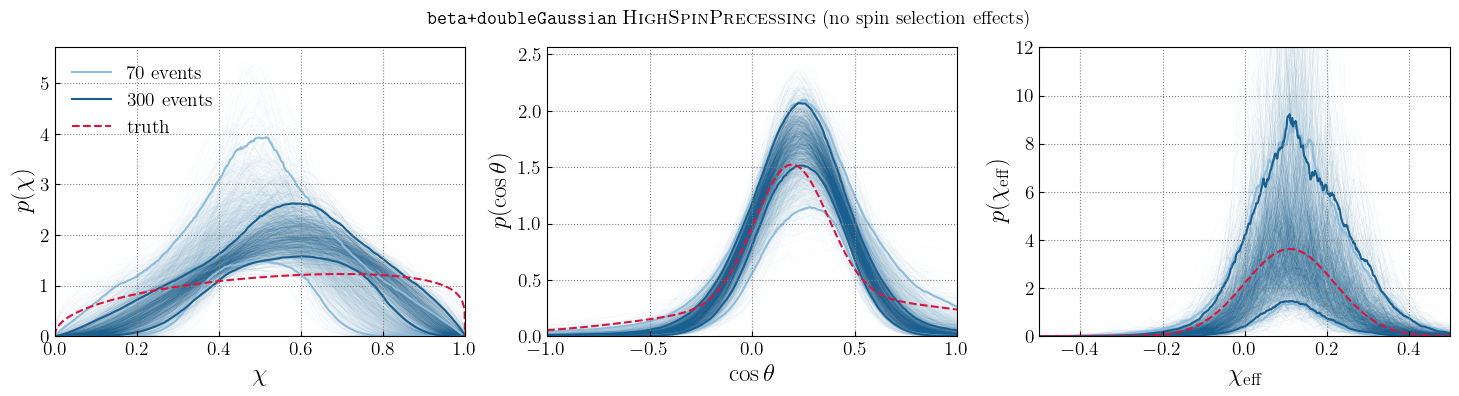

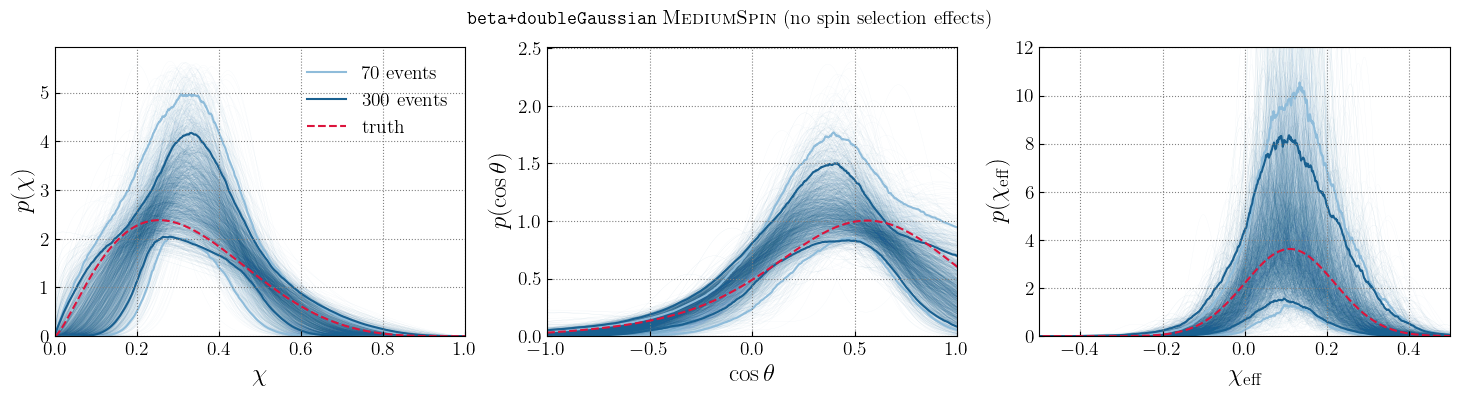

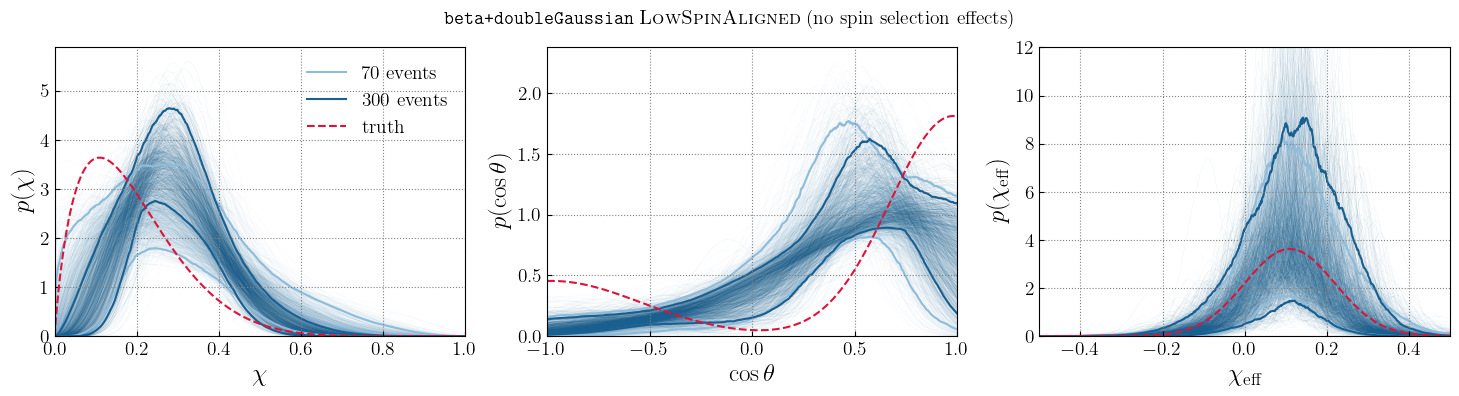

In [8]:
# Define a grid of effective spins
chi_grid = np.linspace(0,1,1000)
cost_grid = np.linspace(-1,1,1000)
chieff_grid = np.linspace(-0.6,0.6,1000)

# Choose a number of traces to draw
nTracesMax = 1000

for pop in pops: 
    
    # Set up fig and axes
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,3.75))
    
    for nevent in nevents: 
            
        # Fetch data
        pop_key = 'pop '+pop
        nevent_key = nevent+' events'
        data = data_dict[pop_key][nevent_key]
        
        # Instantiate an array to hold a collection of traces
        nTraces = min(nTracesMax, len(data['mu_chi']['processed']))
        p_chi = np.zeros((nTraces,chi_grid.size))
        p_cost = np.zeros((nTraces,cost_grid.size))
        p_chieff = np.zeros((nTraces,chieff_grid.size))

        # For a random set of posterior samples, compute and store the corresponding probability densities across our grid
        random_indices = np.random.choice(np.arange(len(data['mu_chi']['processed'])), size=nTraces,replace=False)
        for i,ind in enumerate(random_indices):

            mu_chi = data['mu_chi']['processed'][ind]
            sigma_chi = data['sigma_chi']['processed'][ind]
            mu1_cost = data['mu1_cost']['processed'][ind]
            sigma1_cost = data['sigma1_cost']['processed'][ind]
            mu2_cost = data['mu2_cost']['processed'][ind]
            sigma2_cost = data['sigma2_cost']['processed'][ind]
            MF_cost = data['MF_cost']['processed'][ind]
            Bq = data['Bq']['processed'][ind]

            # calculate beta distribution for chi
            a,b = mu_sigma2_to_a_b(mu_chi, sigma_chi**2)
            p_chi[i,:] = calculate_betaDistribution(chi_grid, a, b)

            # and gaussian distribution for cos(theta)
            p_cost[i,:] = calculate_Double_Gaussian(cost_grid, mu1_cost, sigma1_cost, mu2_cost, sigma2_cost, MF_cost, -1, 1)   
            
            # inferred chi-eff distribution
            chi_effs = draw_chiEffs_and_chiPs_betaDoubleGauss(mu_chi, sigma_chi, mu1_cost, sigma1_cost, mu2_cost, sigma2_cost, MF_cost, Bq, n=1000)[0]
            chieff_kde = gaussian_kde(chi_effs)
            p_chieff[i,:] = chieff_kde(chieff_grid)

        # Plot individual traces
        axes[0].plot(chi_grid, p_chi.T,color=nevents_colors_dict[nevent_key], lw=0.15, alpha=0.15, zorder=0)
        axes[1].plot(cost_grid, p_cost.T,color=nevents_colors_dict[nevent_key], lw=0.15, alpha=0.15, zorder=0)
        axes[2].plot(chieff_grid, p_chieff.T,color=nevents_colors_dict[nevent_key], lw=0.15, alpha=0.15, zorder=0)

        # Also plot 5% and 95% credible bounds
        axes[0].plot(chi_grid, np.quantile(p_chi,0.05,axis=0), color=nevents_colors_dict[nevent_key], zorder=1, label=nevent_key)
        axes[0].plot(chi_grid, np.quantile(p_chi,0.95,axis=0), color=nevents_colors_dict[nevent_key], zorder=1)
        axes[1].plot(cost_grid, np.quantile(p_cost,0.05,axis=0), color=nevents_colors_dict[nevent_key], zorder=1)
        axes[1].plot(cost_grid, np.quantile(p_cost,0.95,axis=0), color=nevents_colors_dict[nevent_key], zorder=1)
        axes[2].plot(chieff_grid, np.quantile(p_chieff,0.05,axis=0), color=nevents_colors_dict[nevent_key], zorder=1)
        axes[2].plot(chieff_grid, np.quantile(p_chieff,0.95,axis=0), color=nevents_colors_dict[nevent_key], zorder=1)

    # Plot true distributions distributions 
    mu_chi_true = hyperparams[pop][0]
    sigma_chi_true = hyperparams[pop][1]
    a_true, b_true = mu_sigma2_to_a_b(mu_chi_true, sigma_chi_true**2)
    p_chi_true = calculate_betaDistribution(chi_grid, a_true, b_true)
    mu1_cost_true =  hyperparams[pop][2]
    sigma1_cost_true = hyperparams[pop][3]
    mu2_cost_true =  hyperparams[pop][4]
    sigma2_cost_true = hyperparams[pop][5]
    MF_cost_true = hyperparams[pop][6]
    Bq_true = hyperparams[pop][7]
    p_cost_true = calculate_Double_Gaussian(cost_grid, mu1_cost_true, sigma1_cost_true, mu2_cost_true, sigma2_cost_true, MF_cost_true, -1, 1)
    axes[0].plot(chi_grid, p_chi_true, color='crimson', ls='--', zorder=2, label='truth')
    axes[1].plot(cost_grid, p_cost_true ,color='crimson', ls='--', zorder=2)
    
    chi_effs_true = draw_chiEffs_and_chiPs_betaDoubleGauss(mu_chi_true, sigma_chi_true, mu1_cost_true, 
                                                           sigma1_cost_true, mu2_cost_true, sigma2_cost_true, 
                                                           MF_cost_true, Bq_true, mCut=8, n=1000)[0]
    
    p_chieff_true = calculate_Gaussian_1D(chieff_grid, 0.11, 0.11, -1, 1)
    axes[2].plot(chieff_grid, p_chieff_true, color='crimson', ls='--', zorder=2)

    axes[0].set_xlim(0,1)
    axes[0].set_ylim(0,)
    axes[0].set_xlabel(r'$\chi$',fontsize=18)
    axes[0].set_ylabel(r'$p(\chi)$',fontsize=18)
    legend_loc = 'upper left' if pop=='1' else 'upper right'
    axes[0].legend(loc=legend_loc)

    axes[1].set_xlim(-1,1)
    axes[1].set_ylim(0,)
    axes[1].set_xlabel(r'$\cos \theta$',fontsize=18)
    axes[1].set_ylabel(r'$p(\cos \theta)$',fontsize=18)
    
    axes[2].set_xlim(-0.5,0.5)
    axes[2].set_ylim(0,12)
    axes[2].set_xlabel(r'$\chi_\mathrm{eff}$',fontsize=18)
    axes[2].set_ylabel(r'$p(\chi_\mathrm{eff})$',fontsize=18)

    plt.suptitle(r'$\texttt{beta+doubleGaussian}$ ' +population_labels_dict[pop_key]+ ' (no spin selection effects)', fontsize=14)

    plt.show()